Requirements
* python 3.11.11(.conda env)*
* pip 24.3.1*
* OpenCV
* pyautogui
* pydirect input


# Libraries

In [4]:
# %pip install keyboard
# %pip install mss
# %pip install numpy
# %pip install matplotlib
# %pip install opencv-python

import pyautogui as py
import pydirectinput
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL as ImageGrab
import pyautogui as py
import pydirectinput
import keyboard
import numpy as np
import cv2 as cv
import os
import math
import time
import numpy
from mss import mss

# Image Processing / Collection

# Edge detection using Canny Edge Detection 

In [5]:
def canny_edge_detection(img):

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY )
    kernel = 5
    blur = cv.GaussianBlur(gray, (kernel, kernel),0)
    canny = cv.Canny(blur, 70, 150)
    
    return canny

# Region of Interest

In [6]:
def roi(img):
    height = img.shape[0]
    width = img.shape[1]
    
    # Road mask
    mask = np.zeros_like(img)
    # car_mask = np.zeros_like(img)
    
    # Define the coordinates for the trapezoid region
    # Adjust these points based on the shape of the lane and the car's position
    roi_points = np.array([
    [((300), (230)),    # Top-left corner
     ((600), (230)),    # Top-right corner     
     ((900), (300)),    # Bottom-right corner
     ((0),  (300))]    # Bottom-left corner    
    ], np.int32)

    # Fill the triangular region
    cv.fillPoly(mask, roi_points, 255)
    #cv.fillPoly(mask, [car_triangle],0)
    
    # Use bitwise_and to apply the mask
    masked_image = cv.bitwise_and(img, mask)
    
    # cv.imshow("ROI Applied", masked_image)
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    
    return masked_image


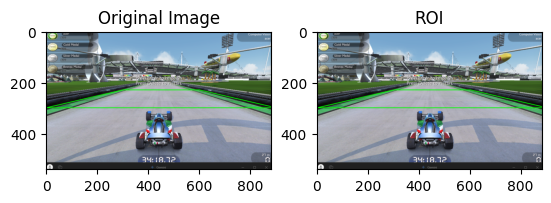

In [7]:
def draw_road_roi(img):
    height, width = img.shape[0], img.shape[1]
    # HARDCODE
    roi_points = np.array([
    [((300), (230)),    # Top-left corner
     ((600), (230)),    # Top-right corner     
     ((900), (300)),    # Bottom-right corner
     ((0),  (300))]    # Bottom-left corner    
    ], np.int32)

    # Draw the triangle on the image for visualization
    cv.polylines(img, [roi_points], isClosed=True, color=(0, 255, 0), thickness=2)
    return img

# Example usage:
# img_cvt = takeSS()  # Capture screenshot and convert

img = cv.imread('D:/Thinkin in programming/Metopen/try this/screenshot_1.png')
img_with_triangle = draw_road_roi(img)
    # skyview = cv.warpPerspective(img, matrix, (width, height))

    # return skyview
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(img_with_triangle, cv.COLOR_BGR2RGB))
plt.title("ROI")

plt.show()


# Dynamic ROI 

In [8]:
def dynamic_roi(img):
    height, width = img.shape

    # use a percentage of the image height to determine the y-coordinate of the triangle's apex
    top_width_ratio = 0.4
    bottom_width_ratio = 1.0

    # calculate points dynamically based on the image size
    top_left = (int(width * (0.5 - top_width_ratio/2)), int(height * 0.6))
    top_right = (int(width * (0.5 + top_width_ratio/2)), int(height * 0.6))
    bottom_left = (0, height)
    bottom_right = (width, height)

    roi_points = np.array([[top_left, top_right, bottom_right, bottom_left]], dtype=np.int32)

    # Draw the triangle on the image for visualization
    mask = np.zeros_like(img)
    cv.fillPoly(mask, [roi_points], 255)
    masked_image = cv.bitwise_and(img, mask)

    return masked_image

# Histogram Intensity 🥹🥹🥹
https://github.com/Infinem/Invenimus-Project/blob/master/lane_detection_with_memory/lane_detection_algorithm.py

In [10]:
def histogram (img):
    histogram = np.sum(img, axis = 0)

    # Find mid point on histogram
    midpoint = np.int32(histogram.shape[0]/2)

    # Compute the left max
    left_X = np.argmax(histogram[:midpoint])
    right_X = np.argmax(histogram[midpoint:]) + midpoint

    return left_X, right_X

img = cv.imread('D:/Thinkin in programming/Metopen/my_game_screenshots/screenshot_5.png')
left_X, right_X = histogram(img)
print(f"Left X: {left_X}, Right X: {right_X}")

Left X: 957, Right X: 849


with the following arguments:
* dst: Output of the edge detector. It should be a grayscale image (although in fact it is a binary one)
* lines: A vector that will store the parameters (r,θ) of the detected lines
* rho : The resolution of the parameter r in pixels. We use 1 pixel.
* theta: The resolution of the parameter θ in radians. We use 1 degree (CV_PI/180)
* threshold: The minimum number of intersections to "*detect*" a line
* srn and stn: Default parameters to zero. Check OpenCV reference for more info.

# Perspective Transform 😫😫

Source points (trapezoid): You have four points on the game screen that define the trapezoidal region you want to transform (e.g., the area in front of the car).

Destination points (rectangle): These points should map the trapezoid into a rectangle (the skyview). The top corners of the trapezoid should become the top corners of the rectangle, and the bottom corners of the trapezoid should become the bottom corners of the rectangle.

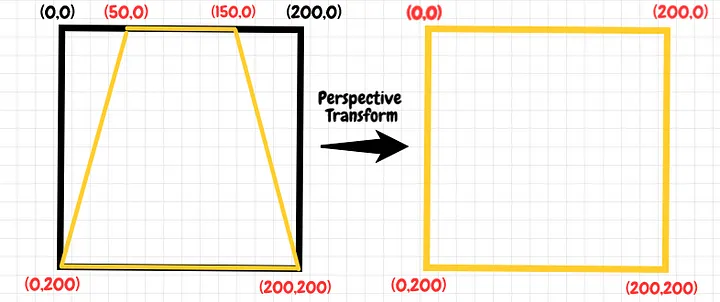

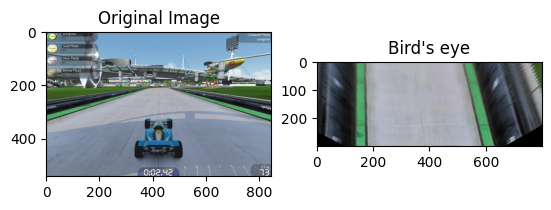

In [11]:
def warp():

    # Get the height and width of the image.
    # The offset ensures that the bird's-eye view isn't stretched too much.
    offset = 100

    # Perspective points (source points) from the original image.
    # These are the four points you want to transform from the source image.
    '''roi_points = np.array([
    [((300), (230)),    # Top-left corner
     ((580), (230)),    # Top-right corner     
     ((880), (300)),    # Bottom-right corner
     ((0),  (300))]    # Bottom-left corner    
    ], np.int32)'''
    source_points = np.array([
        [300, 230],   # Top-left corner
        [600, 230],   # Top-right corner     
        [900, 300],   # Bottom-right corner
        [0, 300]     # Bottom-left corner    
    ], np.float32)  # Use float32 for getPerspectiveTransform

    ''' The destination points for the perspective transform, where you want
    the source points to be mapped to in the resulting image.
    The offset is used to shrink the window a bit. '''
    destination_points = np.array([
        [offset, 0],               # Top-left corner
        [800 - offset, 0],         # Top-right corner
        [800 - offset, 300],       # Bottom-left corner
        [offset, 300]              # Bottom-right corner
    ], np.float32)
    # Changed the data type to np.float32 for both source_points and destination_points,
    # which is required by cv.getPerspectiveTransform.

    # Create the perspective transformation matrix using the source points 
    # and the destination points.
    matrix = cv.getPerspectiveTransform(source_points, destination_points)
    matrix_inv = cv.getPerspectiveTransform(destination_points, source_points)
    return matrix, matrix_inv

    # Apply the perspective warp transformation to the image, generating a 
    # "skyview" of the image.
def front_to_top(img):
    M,_ =  warp()
    size = (800, 300)

    return cv.warpPerspective(img, M, size, flags=cv.INTER_LINEAR)
def top_to_front(img):
    _,m_inv = warp()
    size = (800, 300)

    return cv.warpPerspective(img, m_inv, size, flags=cv.INTER_LINEAR)


img = cv.imread('D:/Thinkin in programming/Metopen/my_game_screenshots/screenshot_5.png')
output = front_to_top(img)
# cv.imshow('img',img)

plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.title("Bird's eye")

plt.show()


# Adaptive Perspective Transform

In [12]:
def adaptive_warp():
    height, width = img.shape[:2]
    
    # More adaptive source points
    source_points = np.float32([
        [width * 0.2, height * 0.6],   # Top-left
        [width * 0.8, height * 0.6],   # Top-right
        [width, height],                # Bottom-right
        [0, height]                     # Bottom-left
    ])
    
    destination_points = np.float32([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
    ])
    
    matrix = cv.getPerspectiveTransform(source_points, destination_points)
    matrix_inv = cv.getPerspectiveTransform(destination_points, source_points)
    
    return matrix, matrix_inv


def front_to_top(img):
    M,_ =  adaptive_warp()
    size = (800, 300)

    return cv.warpPerspective(img, M, size, flags=cv.INTER_LINEAR)
def top_to_front(img):
    _,m_inv = adaptive_warp()
    size = (800, 300)

    return cv.warpPerspective(img, m_inv, size, flags=cv.INTER_LINEAR)



# Sliding Window

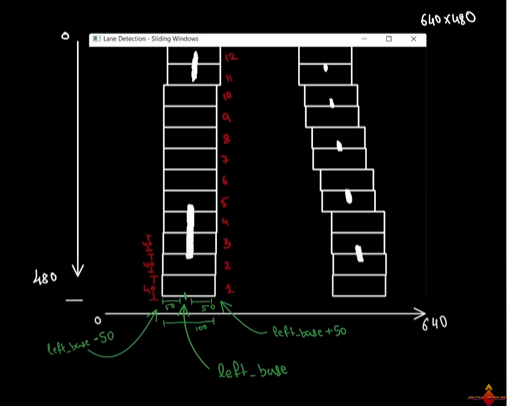

https://github.com/rogersacchelli/Lanes-Detection-with-OpenCV/blob/master/main.py

Look at this reference: https://github.com/Bobeye/Lane_Lines/blob/e14a7298b9ace0f230ffef09589de2047ed8c57d/lane.py

In [26]:
class LaneDetector:
    def __init__(self, img_width, img_height):
        self.img_width = img_width
        self.img_height = img_height
        self.prev_leftx_base = None
        self.prev_rightx_base = None
        self.prev_left_fit = None
        self.prev_right_fit = None
        self.smoothing_factor = 0.7

    # def adaptive_warp(self, img):
    def adaptive_warp(self, car_position_factor=0.0):
        height, width = self.img_height, self.img_width
        top_y = height * (0.6 + car_position_factor * 0*2)
        # height, width = img.shape[:2]
    
        # More adaptive source points
        source_points = np.float32([
            [width * 0.2, top_y],   # Top-left
            [width * 0.8, top_y],   # Top-right
            [width, height],                # Bottom-right
            [0, height]                     # Bottom-left
        ])
        
        destination_points = np.float32([
            [0, 0],
            [width, 0],
            [width, height],
            [0, height]
        ])
        
        matrix = cv.getPerspectiveTransform(source_points, destination_points)
        matrix_inv = cv.getPerspectiveTransform(destination_points, source_points)
        
        return matrix, matrix_inv

    def front_to_top(self, img, car_position_factor=0.0):
        M,_ =  self.adaptive_warp(car_position_factor)
        size = (800, 300)

        return cv.warpPerspective(img, M, (self.img_width, self.img_height), flags=cv.INTER_LINEAR)
    
    def top_to_front(self, img):
        _,m_inv = self.adaptive_warp()
        size = (800, 300)

        return cv.warpPerspective(img, m_inv, size, flags=cv.INTER_LINEAR)

    def sliding_window(self, img_warped):
        histogram = np.sum(img_warped[int(img_warped.shape[0]//2):,:], axis=0)
        # find the peak of the left and right halves of the  histogram
        # this will be the starting points for the left and right lane lines
        output_img = np.zeros_like(img_warped)

        # midpoint = np.int32(histogram.shape[0]//2)
        midpoint = histogram.shape[0]//2
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # lane smoothing
        if self.prev_leftx_base is not None:
            leftx_base = int(self.smoothing_factor * leftx_base + (1 - self.smoothing_factor) * self.prev_leftx_base)
        if self.prev_rightx_base is not None:
            rightx_base = int(self.smoothing_factor * rightx_base + (1 - self.smoothing_factor) * self.prev_rightx_base)

        self.prev_leftx_base = leftx_base
        self.prev_rightx_base = rightx_base

        # Number of sliding windows
        nwindows = 10

        # Set height of windows
        window_height = img_warped.shape[0]//nwindows

        # Identify the x and y positions of all nonzero pixels in the image.
        nonzero = img_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current position to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # set the width of the window
        margin = 100
        # set the minimum number of pixels found to recenter window
        minpix = 50

        # create empty lits to reveive ledt and right lane pixels indices
        left_lane_inds = []
        right_lane_inds = []

        # step through the windows ine by one
        for window in range (nwindows):
            # Identify window boundaries in x and y
            win_y_low =  img_warped.shape[0] - (window+1) * window_height
            win_y_high =  img_warped.shape[0] - window * window_height    

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin

            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin


            cv.rectangle(output_img, (win_xleft_low, win_y_low), 
                         (win_xleft_high, win_y_high), (0,255,0), 2)
            cv.rectangle(output_img, (win_xright_low, win_y_low), 
                         (win_xright_high, win_y_high), (0,255,0), 2)

            # Identify the nonzero pixels in x and y  within the current window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            # append these indices to the list
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # if you dound >  minpix pixels, recenter next window on their mean position
            if len(good_left_inds) >  minpix:
                leftx_current = np.int32(np.mean(nonzerox[good_left_inds]))

            if len(good_right_inds) > minpix:
                rightx_current = np.int32(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds =  np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # fit a second order polynominal to each
        # left_fit = np.polyfit(lefty, leftx, 2)
        # right_fit = np.polyfit(righty, rightx, 2)

        return leftx,  lefty, rightx, righty, output_img


    def fit_polynominal(self, binary_warped):
        leftx, lefty, rightx, righty, out_img = self.sliding_window(binary_warped)

        def filter_outliers(x, y, prev_fit):
            if prev_fit is None or len(x) < 10:
                return x, y
            
            expected_x = prev_fit[0] * y**2 + prev_fit[1] * y + prev_fit[2]
            mask = np.abs(x - expected_x) < 100
            return x[mask], y[mask]
        
        leftx, lefty = filter_outliers(leftx, lefty, self.prev_left_fit)
        rightx, righty = filter_outliers(rightx, righty, self.prev_right_fit)

        if len(leftx) > 50:
            left_fit = np.polyfit(lefty, leftx, 2)
            self.prev_left_fit = left_fit if self.prev_left_fit is None else (
                self.smoothing_factor * self.prev_left_fit + (1 - self.smoothing_factor) * left_fit)
        else:
            left_fit = self.prev_left_fit

        if len(rightx) > 50:
            right_fit = np.polyfit(righty, rightx, 2)
            self.prev_right_fit = right_fit if self.prev_right_fit is None else (
                self.smoothing_factor * self.prev_right_fit + (1 - self.smoothing_factor) * right_fit)
        else:
            right_fit = self.prev_right_fit

        return left_fit, right_fit, out_img


    def draw_lines(self, binary_warped, left_fit, right_fit, original_image):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # generate y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

        # calculate the x values basaed on the polynominal coefficients
        left_fitx = left_fit[0] * ploty**2  + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1]  * ploty + right_fit[2]

        # recast the  x and y points into usable format for cv2.fillPoly()
        left_line_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_line_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        points = np.hstack((left_line_points, right_line_points))
        M, M_inv = self.adaptive_warp()
        # fill the lane area with green
        cv.fillPoly(color_warp , np.int_([points]), (0,255,0))

        # warp the blank back to the original image space using inverse perspective matrix (M_inv)
        newwarp = cv.warpPerspective(color_warp, M_inv, (original_image.shape[1], original_image.shape[0]))

        # combine the result with the original image
        result = cv.addWeighted(original_image, 1, newwarp, 0.3, 0)

        return result

        # calculate  the radius of curvature of the lane and draw it on the image

    @staticmethod
    def capture_game_screen():
        try:
            # intialize the screen capture and match it with the game window
            # 5,30, 847, 542
            sct = mss()
            # monitor = {"top": 5, "left": 30, "width": 847, "height": 542}
            '''Try full scale windows'''
            monitor = {"top": 5, "left": 30, "width": 1270, "height": 813}

            '''
            if you make the game window bigger, it'll be easier to capture the screen
            and you can also adjust the monitor dictionary values to match the game window
            
            '''
            # monitor = {"top": 0, "left": 0, "width": 1920, "height": 1080}
            

            # capture the screen
            screenshot = sct.grab(monitor)
            # conver to numpy array
            frame = np.array(screenshot)
            # convert from RGBA to BGR
            frame = cv.cvtColor(frame, cv.COLOR_RGBA2BGR)
            return frame
        except Exception as e:
            print(f"Screen capture failed: {e}")
            return None

    def process_frame(self, image):
        # Process the image
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        blur = cv.GaussianBlur(gray, (5, 5), 0)
        canny_image = cv.Canny(blur, 50, 150)
        
        # Bird's eye view transformation
        img_warp = self.front_to_top(canny_image)
        
        # Fit polynomials
        try:
            left_fit, right_fit, out_img = self.fit_polynominal(img_warp)
            # Draw the detected lane lines
            result = self.draw_lines(img_warp, left_fit, right_fit, image)
        except Exception as e:
            print(f"Error in lane detection: {e}")
            return canny_image, img_warp, image
        
        return canny_image, img_warp, result

    @classmethod
    def display_pipeline(cls):
        # Initialize detector with dummy size (will be updated with first frame)
        detector = None
        
        cv.namedWindow('Canny Edge Detection', cv.WINDOW_NORMAL)
        cv.namedWindow('Bird\'s Eye View', cv.WINDOW_NORMAL)
        cv.namedWindow('Detected Lane Lines', cv.WINDOW_NORMAL)

        while True:
            # Capture game screen
            frame = cls.capture_game_screen()
            if frame is None:
                print("Failed to capture frame")
                continue
                
            # Initialize detector with first frame
            if detector is None:
                detector = cls(frame.shape[1], frame.shape[0])
            
            try:
                # Process the frame
                canny_img, bird_view, lane_detection = detector.process_frame(frame)
                
                # Resize windows for better viewing
                window_width = 640
                window_height = 480
                
                canny_resized = cv.resize(canny_img, (window_width, window_height))
                bird_view_resized = cv.resize(bird_view, (window_width, window_height))
                lane_detection_resized = cv.resize(lane_detection, (window_width, window_height))
                
                # Show all windows
                cv.imshow('Canny Edge Detection', canny_resized)
                cv.imshow('Bird\'s Eye View', bird_view_resized)
                cv.imshow('Detected Lane Lines', lane_detection_resized)
                
            except Exception as e:
                print(f"Error processing frame: {e}")
                
            if cv.waitKey(1) & 0xFF == ord('q'):
                break

        cv.destroyAllWindows()

# Run the pipeline
if __name__ == "__main__":
    LaneDetector.display_pipeline()


Error in lane detection: 'NoneType' object is not subscriptable
Error in lane detection: 'NoneType' object is not subscriptable


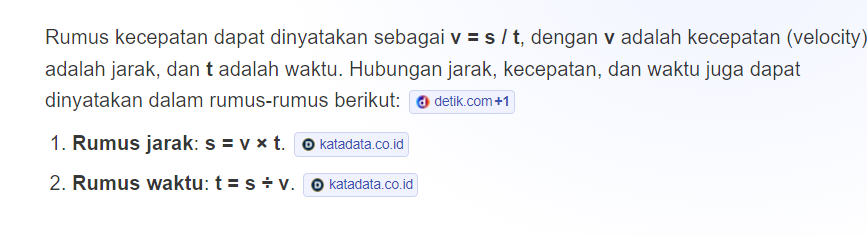

# Debug

In [64]:
# debug line detection
img = cv.imread('D:/Thinkin in programming/Metopen/try this/screenshot_1.png')
canny_img = canny_edge_detection(img)
masked_img = roi(canny_img)
img_warp = front_to_top(masked_img)
left_fit, right_fit, out_img = fit_polynominal(img_warp)
result = draw_lines(img_warp, left_fit, right_fit, img)

cv.imshow('masked', masked_img)
cv.imshow('img_warp', img_warp)
cv.imshow('result', result)
cv.waitKey(0)
cv.destroyAllWindows()

# Controll the car with Direct Input

In [20]:
class LaneFollowingControl:
    def __init__(self):
        self.sct  = mss()
        self.monitor = {"top": 5, "left": 30, "width": 847, "height": 542}

        # controll parameters
        self.center_threshold = 100 # pixel from the center before steering
        self.turn_duration = 0.1  # base turning duration
        self.last_turn_time = 0
        self.turn_cooldown = 0.2  # minimum time between turns

    def capture_and_process(self):
        screenshot = self.sct.grab(self.monitor)
        frame = numpy.array(screenshot)        
        frame = cv.cvtColor(frame, cv.COLOR_RGBA2BGR)


        # Process the frame
        canny_image = canny_edge_detection(frame)
        masked_image = roi(canny_image)
        img_warp = front_to_top(masked_image)
        left_fit, right_fit, out_img = LaneDetector.fit_polynominal(img_warp)

        return frame, left_fit, right_fit, canny_image, img_warp, out_img
    
    def calculate_steering(self, left_fit, right_fit):
        #  Calculate the center of the lane at the bottom of the image
        y_eval = 720
        left_x = left_fit[0]*y_eval + left_fit[1]*y_eval + left_fit[2]
        right_x = right_fit[0]*y_eval + right_fit[1]*y_eval + right_fit[2]

        # calculate center of the lane
        lane_center = (left_x + right_x) / 2

        # Assume center of the car is middle of the image
        car_center = self.monitor["width"] / 2

        # calculate the offset
        offset = lane_center - car_center

        # calculate curvature
        curvature = (left_fit[0] + right_fit[0]) / 2

        return offset, curvature
    
    def control_car(self, offset, curvature):
        current_time = time.time()
        
        # Only execute turn if cooldown has elapsed
        if current_time - self.last_turn_time < self.turn_cooldown:
            return
        
        # Basic steering logic
        if abs(offset) > self.center_threshold:
            # Adjust turn duration based on offset magnitude
            turn_time = min(abs(offset) / 1000, 0.3)  # Max 0.3 seconds
            
            if offset > 0:  # Need to turn right
                pydirectinput.keyDown('d')
                time.sleep(turn_time)
                pydirectinput.keyUp('d')
            else:  # Need to turn left
                pydirectinput.keyDown('a')
                time.sleep(turn_time)
                pydirectinput.keyUp('a')
                
            self.last_turn_time = current_time

        # Always accelerate (you might want to adjust this based on curvature)
        pydirectinput.keyDown('up')

def main():
    # Initialize controller
    controller = LaneFollowingControl()
    
    # Create display windows
    cv.namedWindow('Lane Detection', cv.WINDOW_NORMAL)
    
    # Click to focus game window (adjust coordinates as needed)
    py.click(409, 275)
    time.sleep(0.5)
    
    try:
        while True:
            # Capture and process frame
            frame, left_fit, right_fit, canny_img, img_warp, out_img = controller.capture_and_process()
            
            # Calculate steering
            offset, curvature = controller.calculate_steering(left_fit, right_fit)
            
            # Control the car
            controller.control_car(offset, curvature)
            
            # Display the output
            cv.imshow('Lane Detection', out_img)
            
            # Exit if 'q' is pressed
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        # Clean up
        cv.destroyAllWindows()
        pydirectinput.keyUp('up')  # Make sure we release accelerator
        pydirectinput.keyUp('a')
        pydirectinput.keyUp('d')

if __name__ == "__main__":
    main()